In [ ]:
# Import all the needed packages
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import matplotlib.pyplot as plt

In [6]:
# Split the dataset into training set and test set
numeric_data = pd.read_csv(
    'numeric_dataset.csv',
    engine="python", 
    sep=None           # auto-detects delimiter
)

y = numeric_data['Approved'].values
X = numeric_data.drop(columns=['Approved']).values   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
#Logistic Regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(solver="saga", max_iter=5000, n_jobs=-1))
])

param_grid = {
    "logit__penalty": ["l2", "l1"],
    "logit__C": [0.01, 0.1, 1.0, 10.0],
    "logit__class_weight": [None, "balanced"],   # try if classes are imbalanced
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",   # ranking metric, good for probabilities
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

gs.fit(X_train, y_train)
best_clf = gs.best_estimator_
print("Best params:", gs.best_params_)

Best params: {'logit__C': 0.01, 'logit__class_weight': 'balanced', 'logit__penalty': 'l1'}


In [8]:
# Evaluate probability quality
proba_test = best_clf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, proba_test))
print("PR AUC:", average_precision_score(y_test, proba_test))  # useful for imbalance
print("Log Loss:", log_loss(y_test, proba_test))               # proper scoring rule
print("Brier Score:", brier_score_loss(y_test, proba_test))    # calibration-focused

ROC AUC: 0.732415205462471
PR AUC: 0.9917978974303331
Log Loss: 0.5794855515975231
Brier Score: 0.19437928585120676


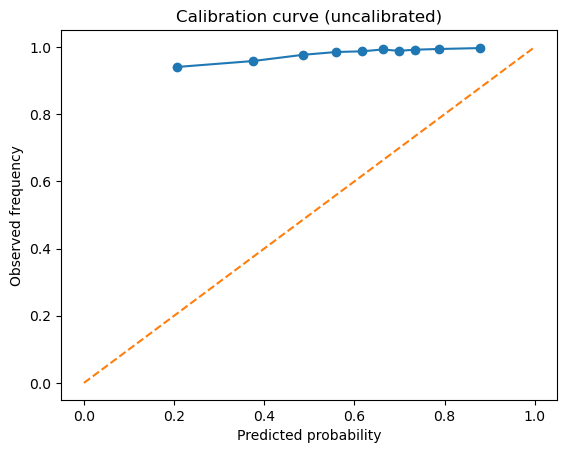

In [9]:
# Visual Calibration check
frac_true, frac_pred = calibration_curve(y_test, proba_test, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(frac_pred, frac_true, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve (uncalibrated)")
plt.show()

In [10]:
# Calibration
calibrated = CalibratedClassifierCV(best_clf, method="isotonic", cv=5)  # or method="sigmoid"
calibrated.fit(X_train, y_train)

proba_test_cal = calibrated.predict_proba(X_test)[:, 1]
print("Brier (calibrated):", brier_score_loss(y_test, proba_test_cal))
print("Log Loss (calibrated):", log_loss(y_test, proba_test_cal))

c:\Users\66432\miniconda3\envs\mude-week-2-6\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\66432\miniconda3\envs\mude-week-2-6\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Brier (calibrated): 0.018382072476035127
Log Loss (calibrated): 0.08751749686401089


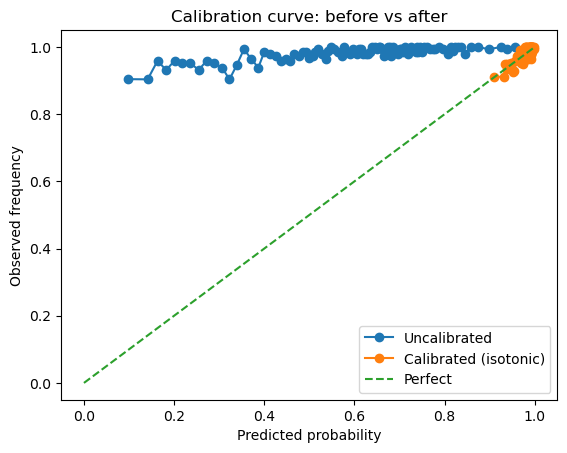

In [19]:
# Uncalibrated
frac_true_u, frac_pred_u = calibration_curve(y_test, proba_test, n_bins=100, strategy="quantile")

# Calibrated
frac_true_c, frac_pred_c = calibration_curve(y_test, proba_test_cal, n_bins=100, strategy="quantile")

plt.figure()
plt.plot(frac_pred_u, frac_true_u, marker="o", label="Uncalibrated")
plt.plot(frac_pred_c, frac_true_c, marker="o", label="Calibrated (isotonic)")
plt.plot([0,1],[0,1],"--", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve: before vs after")
plt.legend()
plt.show()


In [13]:
target_col = "Approved"

# 1) Feature columns (keeps original order)
feature_cols = numeric_data.drop(columns=[target_col]).columns.tolist()

# 2) Train split using those columns
X = numeric_data[feature_cols].to_numpy()
y = numeric_data[target_col].to_numpy()


In [ ]:
# save the calibrated model
import joblib, sklearn, json, time

artifact = {
    "model": calibrated,                    # or best_clf if you’re not using calibration
    "feature_cols": feature_cols,           # exact training column order
    "sklearn_version": sklearn.__version__,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
}

joblib.dump(artifact, "logit_calibrated.joblib", compress=3)

['logit_calibrated.joblib']

In [15]:
import os
print("Exists?", os.path.exists("logit_calibrated.joblib"))
print("Size (MB):", os.path.getsize("logit_calibrated.joblib")/1024/1024)

Exists? True
Size (MB): 0.058373451232910156


In [22]:
# Inspect coefficients
coef = best_clf.named_steps["logit"].coef_.ravel()
intercept = best_clf.named_steps["logit"].intercept_[0]
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("coef", ascending=False)
display(coef_df)

,feature,coef,odds_ratio
560,Aanvraag_Laatste_Locatie_Dienstregelpunt_Std,0.207274,1.230320
264,Aanvraag_Eerste_Locatie_Dienstregelpunt_Tbi,0.170159,1.185494
507,Aanvraag_Laatste_Locatie_Dienstregelpunt_Mvtaho,0.155032,1.167696
508,Aanvraag_Laatste_Locatie_Dienstregelpunt_Mvtahw,0.128321,1.136917
423,Aanvraag_Laatste_Locatie_Dienstregelpunt_Erpw,0.103259,1.108778
...,...,...,...
528,Aanvraag_Laatste_Locatie_Dienstregelpunt_Odzg,-0.197461,0.820812
2,Tolerance,-0.210881,0.809871
589,Aanvraag_Laatste_Locatie_Dienstregelpunt_Vlgr,-0.216702,0.805170
315,Aanvraag_Eerste_Locatie_Dienstregelpunt_Zvg,-0.253530,0.776057


In [ ]:
# Predict a probability for a new request
